If you plan on using this implementation, please cite our work:

@INPROCEEDINGS{Grabowski2021IGARSS,
author={Grabowski, Bartosz and Ziaja, Maciej and Kawulok, Michal
and Nalepa, Jakub},
booktitle={IGARSS 2021 - 2021 IEEE International Geoscience
and Remote Sensing Symposium},
title={Towards Robust Cloud Detection in
Satellite Images Using U-Nets},
year={2021},
note={in press}}

# Panchromatic data clustering example

At first import all necessary libraries.

In [1]:
import json
import os
from pathlib import Path

import PIL
import numpy as np
import spectral.io.envi as envi
from IPython.display import display
from PIL import Image
from skimage import img_as_ubyte
from skimage.color import label2rgb
from skimage.io import imsave
from tensorflow.keras.preprocessing.image import load_img

from cloud_detection.scripts.cluster import CLUSTERS, METRICS, BACKGROUND_LABEL
# It is necessary for such large images to change the max pixel setting in PIL.
PIL.Image.MAX_IMAGE_PIXELS = 310000000

c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\łukasz\desktop\machine-learning\ve

Now specify the path to the data and ground-truth files. Both should be in the
same `base` directory.
Additionally, we set the name of the clustering algorithm. The possible
options are `km` and `gm` which stand for K-Means and Gaussian Mixture Model
respectively. And finally, we specify the target value for the
total number of groups.

In [2]:
img_base_path = Path('')
dest_path = os.path.join('../examples', 'clustering_results')
n_clusters = 3
alg = 'km'

Now open and load the data and ground-truth data.

In [3]:
gt = envi.open(list(img_base_path.glob("*_fixedmask.hdr"))[0])
gt = np.array(gt.open_memmap(), dtype=np.int)
gt = np.where(gt > 128, 1, 0)
img = np.array(load_img(list(img_base_path.glob('*_B8.TIF'))[0],
                                color_mode='grayscale',
                                target_size=gt.shape))

mask = np.where(img != BACKGROUND_LABEL)
data = np.expand_dims(img[mask].ravel(), -1)

After the data is loaded, group the samples, predict the cluster labels
and calculate the metrics to validate the quality of
the unsupervised segmentation process. This process might take a while.

In [4]:
y_true = gt[mask].ravel()
y_pred = CLUSTERS[alg](n_clusters, random_state=0).fit_predict(data)
metrics = {key: f(labels_true=y_true, labels_pred=y_pred)
            for key, f in METRICS.items()}

Save the resulted maps as images to visually verify the clustering performance.

In [5]:
os.makedirs(dest_path, exist_ok=True)
predicted_map = np.full(img.shape, -1)
predicted_map[mask] = y_pred
np.savetxt(os.path.join(dest_path, f'{n_clusters}-predicted-map.txt'),
           predicted_map, fmt='%i')
imsave(os.path.join(dest_path, f'{n_clusters}-predicted-map.png'),
       img_as_ubyte(label2rgb(predicted_map)))

gt_map = np.full(img.shape, -1)
gt_map[mask] = y_true
np.savetxt(os.path.join(dest_path, f'ground-truth-map.txt'), gt_map, fmt='%i')
imsave(os.path.join(dest_path, f'ground-truth-map.png'),
       img_as_ubyte(label2rgb(gt_map)))

Image.fromarray(img).save(os.path.join(dest_path,'original-map.png'))


c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  
c:\users\łukasz\desktop\machine-learning\venv\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


Save the metrics to an output file and show them.

In [6]:
with open(os.path.join(dest_path, 'metrics.json'),
          'w') as metrics_file:
    json.dump(metrics, metrics_file, ensure_ascii=False, indent=4)
print(metrics)

{'nmi': 0.12317484074984525, 'ars': 0.05073904642552666}


View the images to verify visually the performance of the segmentation.

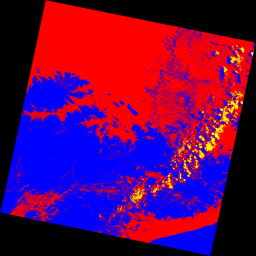

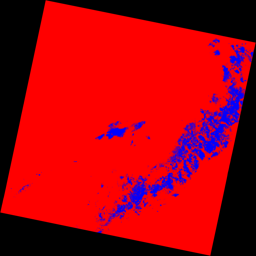

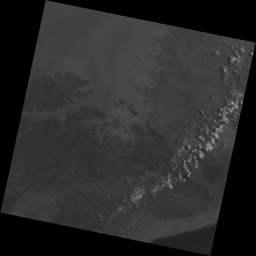

In [7]:

display(Image.open('clustering_results/3-predicted-map.png',
                   'r').resize((256, 256)))
display(Image.open('clustering_results/ground-truth-map.png',
                   'r').resize((256, 256)))
display(Image.open('clustering_results/original-map.png',
                   'r').resize((256, 256)))
